In [1]:
import numpy as np # to handle matrix and data operation
import pandas as pd # to read csv and handle dataframe

import torch # to load pytorch library
import torch.nn as nn # to load pytorch library
import torch.nn.functional as F # to load pytorch function
import torch.utils.data # to load data processor
from torch.autograd import Variable # pytorch data type
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59999 entries, 0 to 59998
Columns: 785 entries, 5 to 0.617
dtypes: int64(785)
memory usage: 359.3 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9999 entries, 0 to 9998
Columns: 785 entries, 7 to 0.667
dtypes: int64(785)
memory usage: 59.9 MB


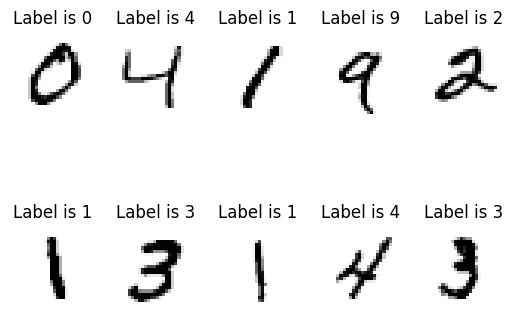

In [2]:
train = pd.read_csv('mnist_data/mnist_train.csv')
test = pd.read_csv('mnist_data/mnist_test.csv')
train.info()
test.info()

# split image and label
train_label = train.iloc[:, 0].values
train_img = train.iloc[:, 1:]
test_label = test.iloc[:, 0].values
test_img = test.iloc[:, 1:]
# check the dataset of one example
count=1
for a in range (10):
    imarray = train_img.iloc[a, :].values.reshape(28,28)
    plt.subplot(2,5,count)
    plt.subplots_adjust(hspace=0.1)
    count += 1
    plt.axis('off')
    plt.title("Label is " + str(train_label[a]))
    plt.imshow(imarray, cmap='Greys', interpolation='None')

In [3]:
# reshape to be [samples][pixels][width][height]
train_img = train_img.values.reshape(-1,1,28,28)
test_img = test_img.values.reshape(-1,1,28,28)
train_img = train_img / 255.0
test_img = test_img / 255.0
# normalize inputs from 0-255 to 0-1
print(train_img.shape)
print(train_label.shape)
print(test_img.shape)
print(test_label.shape)

BATCH_SIZE = 1000

# create feature and targets tensor for training set.
torch_X_train = torch.from_numpy(train_img).float()
torch_y_train = torch.from_numpy(train_label)
# create feature and targets tensor for testing set.
torch_X_test = torch.from_numpy(test_img).float()
torch_y_test = torch.from_numpy(test_label)
# Pytorch train and test sets
train = torch.utils.data.TensorDataset(torch_X_train,torch_y_train)
test = torch.utils.data.TensorDataset(torch_X_test,torch_y_test)

# data loader
train_loader = torch.utils.data.DataLoader(train, batch_size = BATCH_SIZE, shuffle = False, num_workers=4)
test_loader = torch.utils.data.DataLoader(test, batch_size = BATCH_SIZE, shuffle = False, num_workers=4)

(59999, 1, 28, 28)
(59999,)
(9999, 1, 28, 28)
(9999,)


In [4]:
# Defining the network (LeNet-5)
class LeNet5(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2)
        self.act1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0)
        self.act2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(in_features=400, out_features=120)
        self.act3 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.act4 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        #Convolutional Layer/Pooling Layer/Activation
        x = self.conv1(x)
        x = self.act1(x)
        x = self.maxpool1(x)
        #Convolutional Layer/Dropout/Pooling Layer/Activation
        x = self.conv2(x)
        x = self.act2(x)
        x = self.maxpool2(x)
        x = x.view(-1, 400)
        #Fully Connected Layer/Activation
        x = self.fc1(x)
        x = self.act3(x)
        #Fully Connected Layer/Activation
        x = self.fc2(x)
        x = self.act4(x)

        return self.fc3(x)

criterion = nn.CrossEntropyLoss()
if torch.cuda.is_available():
    criterion = criterion.cuda()


In [5]:
def train(model, epoch, optimizer):
    model.train()
    epoch_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        #Variables in Pytorch are differenciable.
        data, target = Variable(data), Variable(target)
        #This will zero out the gradients for this batch.
        optimizer.zero_grad()
        output = model(data)
        # Calculate the loss The negative log likelihood loss. It is useful to train a classification problem with C classes.
        loss = criterion(output, target)
        #dloss/dx for every Variable
        loss.backward()
        #to do a one-step update on our parameter.
        optimizer.step()
        epoch_loss += loss.item()
    #Print out the loss periodically.
    avg_loss = epoch_loss / len(train_loader)
    print("===> Epoch {} Complete: Training loss: {:.4f}".format(epoch, avg_loss))
    return avg_loss

In [6]:
def train_accuracy(model, epoch):
    model.eval()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
        _, predicted = torch.max(output.data, 1) # get the index of the max log-probability
        correct += (predicted == target).sum().item()
    avg_accuracy = correct / len(train_loader.dataset)
    print("===> Epoch {} Complete: Training accuracy: {:.4f}%".format(epoch, 100. * avg_accuracy))
    return avg_accuracy

In [7]:
def test(model, epoch):
    model.eval()
    correct = 0
    for batch_idx, (data, target) in enumerate(test_loader):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()
            
        data, target = Variable(data), Variable(target)
        with torch.no_grad():
            output = model(data)
        _, predicted = torch.max(output.data, 1) # get the index of the max log-probability
        correct += (predicted == target).sum().item()
    avg_accuracy = correct / len(test_loader.dataset)
    print("===> Epoch {} Complete: Testing accuracy: {:.4f}%".format(epoch, 100. * avg_accuracy))
    return avg_accuracy

In [8]:
def checkpoint(model, epoch):
    model_out_path = "Training_epoch_{}.pth".format(epoch)
    torch.save(model.state_dict(), model_out_path)
    print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
model = LeNet5()

if torch.cuda.is_available():
    model.cuda() # set model to use GPU if available, defaults to CPU


optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

**Task 1:**  A full loop that records the training loss and testing accuracy

In [10]:
train_losses = []
train_correct = []
test_correct = []
for epoch in range(1, 51, 1):
    # Training loss
    train_loss = train(model, epoch, optimizer)
    train_losses.append(train_loss)
    
    # Training accuracy
    train_acc = train_accuracy(model, epoch)
    train_correct.append(train_acc)
    
    # Testing accuracy
    test_acc = test(model, epoch)
    test_correct.append(test_acc)
    
    if epoch % 10 == 0:
        # Model checkpointing
        checkpoint(model, epoch)


===> Epoch 1 Complete: Training loss: 2.3022
===> Epoch 1 Complete: Training accuracy: 9.8635%
===> Epoch 1 Complete: Testing accuracy: 9.5810%
===> Epoch 2 Complete: Training loss: 2.2980
===> Epoch 2 Complete: Training accuracy: 9.8635%
===> Epoch 2 Complete: Testing accuracy: 9.5810%
===> Epoch 3 Complete: Training loss: 2.2929
===> Epoch 3 Complete: Training accuracy: 11.6985%
===> Epoch 3 Complete: Testing accuracy: 11.2411%
===> Epoch 4 Complete: Training loss: 2.2854
===> Epoch 4 Complete: Training accuracy: 30.9288%
===> Epoch 4 Complete: Testing accuracy: 30.4830%
===> Epoch 5 Complete: Training loss: 2.2719
===> Epoch 5 Complete: Training accuracy: 41.0190%
===> Epoch 5 Complete: Testing accuracy: 40.0040%
===> Epoch 6 Complete: Training loss: 2.2422
===> Epoch 6 Complete: Training accuracy: 42.1440%
===> Epoch 6 Complete: Testing accuracy: 41.4141%
===> Epoch 7 Complete: Training loss: 2.1422
===> Epoch 7 Complete: Training accuracy: 48.1725%
===> Epoch 7 Complete: Testing a

**Task 2.** Plot the training loss and testing accuracy VS epoches

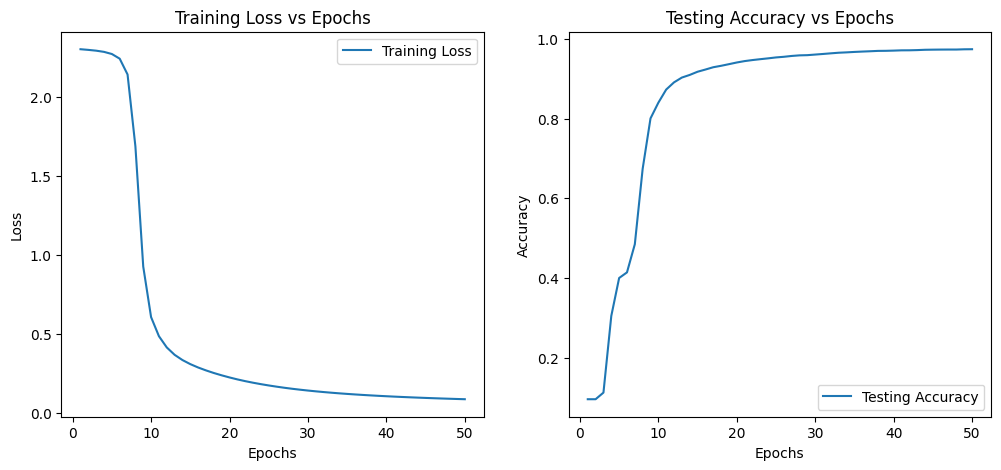

In [22]:
# Plotting the training loss and testing accuracy vs epochs
epoch_count = range(1, 51)

plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(epoch_count, train_losses, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot testing accuracy
plt.subplot(1, 2, 2)
plt.plot(epoch_count, test_correct, label='Testing Accuracy')
plt.title('Testing Accuracy vs Epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend()

plt.show()

**Task 3.** load pre-trained model and visualize the prediction on the testing samples.

C:\Users\Arlis Arto Puidet\AppData\Local\Temp\ipykernel_19944\773316961.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_name, map_

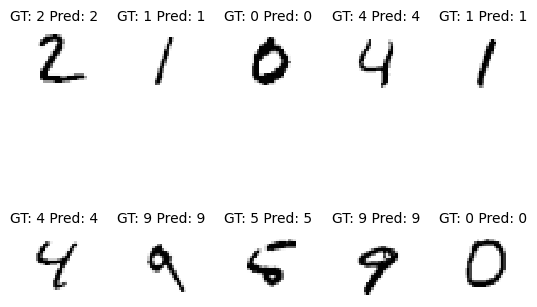

In [14]:
model_name = 'Training_epoch_50.pth'
model.load_state_dict(torch.load(model_name, map_location=lambda storage, loc: storage)) # load the trained model
count=1
model.eval()
for a in range (10):
    imarray = test_img[a].reshape(1,1,28,28)
    data = torch.from_numpy(imarray).float()
    if torch.cuda.is_available():
        data = data.cuda()

    # Fill here:
    # Input the image to the loaded model
    output = model(data)
    # Get the predicted class labels using argmax or max on the model output
    _, predicted = torch.max(output.data, 1)

    
    plt.subplot(2,5,count)
    plt.subplots_adjust(hspace=0.2, wspace = 0.6)
    count += 1
    plt.axis('off')
    plt.title('GT: ' + str(test_label[a]) + ' Pred: ' + str(predicted.item()), fontsize=10)
    plt.imshow(imarray[0,0,:,:], cmap='Greys', interpolation='None')

**Task 4.** Change the learning rate and retrain the model again, plot the new training loss and original training loss in one figure and explain your discovery.

In [ ]:
model2 = LeNet5() # initialize a new model
if torch.cuda.is_available():
    model2.cuda() # Move the model to GPU if available
optimizer2 = ... # Fill a new optimizer

In [ ]:
train_losses = []
train_correct = []
test_correct = []

for epoch in range(1, 51, 1):
    # Training loss
    # Training accuracy
    # Test accuracy
    ...


Plot accuracies and loss